#kaggleチュートリアル
タイタニック号の生き残りの人間を機械学習によって求める.

-----**説明**--------------
----------------------------------
 
タイタニック号は氷山に衝突して沈没し、 2224人の乗員乗客のうち1502人が亡くなりました。 彼らの生死を分けたのは何だったのでしょうか？ 幸運でしょうか？それだけではありません。 実は、ある種の属性を持つ人々はそうでない人々よりも生き延びやすかったのです。 例えば、女性、子供、一等船室の人々は生存確率が高かったことが知られています。

なので、乗客の性別、年齢、船室等級が分かれば、 ある程度はその乗客の生死が予測できるのです。 そして、他の属性も考慮すれば、 その生存予測の正確さを更に向上させられるかもしれません。

コンペ参加者は、このように予測の正確さを向上させて、 他の参加者とその正確さを競います。

引用先▶︎[http://simplestem.hatenablog.com/entry/2016/11/30/230641]

In [0]:
#Importing required packages.
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
%matplotlib inline

#データセットの分析(pandas)
まずはデータを取得してどんなデータが入っているか確かめる.

csvファイルを眺めてもいいがpandasを使えば見たい部分を指定したり欠損データを見ることができる.

In [0]:
train = pd.read_csv("/train.csv")
test = pd.read_csv("/test.csv")

In [0]:
print(train.shape)
train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


データの特徴の分析(matplotlibを使えば散布図,箱ひげ図などすぐに生成可能)

この問題ではあんまり意味ないです

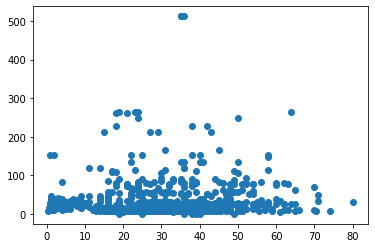

In [0]:
plt.scatter(x = 'Age', y = 'Fare', data = train)

#特徴量エンジニアリング
欠損データがあるとうまく学習ができないため欠損データを調べて整理する。外れ値の除外なども含めて特徴量エンジニアリングと呼ぶらしい

In [0]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [0]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [0]:
train.isnull().sum(axis=1)

0      1
1      0
2      1
3      0
4      1
      ..
886    1
887    0
888    2
889    0
890    1
Length: 891, dtype: int64

In [0]:
train["Age"] = train['Age'].fillna(train['Age'].median())

In [0]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

データセットに自分が必要のないデータが含まれていれば消去することも可能。

名前が生存に密に関係するとは思えないので消してみる。

(自然言語を処理するモジュールもある。ベクトル化とかしてるけど詳しくは知らん、ツイート解析とかレビュー解析に使われています)

In [0]:
train_selfset = train.drop(columns='Name')
train_selfset

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,0,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,1,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,1,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,0,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,0,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,1,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,1,28.0,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,0,26.0,0,0,111369,30.0000,C148,C


#ダミー変数化について
もう一度trainのデータセットを見てみる

In [0]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


上記のデータセットに数値以外が含めれていることが確認できる。以下のようにinfoでも確認可能

このobjectというものが問題で数値に変換されなければ機械学習で読み取ることができない。→数値に変更する

In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [0]:
train["Sex"][train["Sex"] == "male"] = 0
train["Sex"][train["Sex"] == "female"] = 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
test["Age"] = test["Age"].fillna(test["Age"].median())
test["Sex"][test["Sex"] == "male"] = 0
test["Sex"][test["Sex"] == "female"] = 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S


In [0]:
from sklearn import tree
# 「train」の目的変数と説明変数の値を取得
target = train["Survived"].values
features_one = train[["Pclass", "Sex", "Age"]].values
 
# 決定木の作成
my_tree_one = tree.DecisionTreeClassifier()
my_tree_one = my_tree_one.fit(features_one, target)
 
# 「test」の説明変数の値を取得
test_features = test[["Pclass", "Sex", "Age"]].values
 
# 「test」の説明変数を使って「my_tree_one」のモデルで予測
my_prediction = my_tree_one.predict(test_features)

In [0]:
my_prediction

array([0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,

In [0]:
# PassengerIdを取得
PassengerId = np.array(test["PassengerId"]).astype(int)
 
# my_prediction(予測データ）とPassengerIdをデータフレームへ落とし込む
my_solution = pd.DataFrame(my_prediction, PassengerId, columns = ["Survived"])
 
# my_tree_one.csvとして書き出し
my_solution.to_csv("my_tree_one.csv", index_label = ["PassengerId"])